# Assignment 7

## Submit your .ipynb file to Gradescope by Thursday, October 30th **by 10pm**

#### Import the familiar libraries ``pandas``, ``numpy`` and ``matplotlib.pyplot``

#### In addition, we'll import a sublibrary from the ``statsmodels`` library. We'll use this in problems 4 and 5

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

##### Run the code chunk below to read the CSV file named `results.csv` in the `data` folder and print the first 5 rows of the dataset (using a quick alternative to `.iloc[:5,:]`). Browse the dataset.

In [2]:
df_results = pd.read_csv("data/results.csv")
print(df_results.head())

   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   
3            4              4     5.0    58      +17.181      5707797   
4            5              5     4.0    58      +18.014      5708630   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452         218.300         1  
1         41    3 

### (1)  Check Column Types and Data Cleaning

- Use the attributes ``.dtypes`` to get the data types for each column of the DataFrame. Assign this to a variable named ``results_data_types``.
- The 'milliseconds' column contains string values that should be numeric. Do the following:
    - Replace all non-numeric values in the milliseconds column with ``np.nan``
    - Add a new column to ``df_results`` called 'race_time_ms' by converting the 'milliseconds' column to a numeric data type using ``.to_numeric``

In [6]:
# solution 1
col_types = df_results.dtypes

df_non_numeric = df_results.query("milliseconds.str.isnumeric() == False")
unique_vals = pd.unique(df_non_numeric["milliseconds"])
df_results["race_time_ms"] = (pd.to_numeric(df_results["milliseconds"].
                                replace(unique_vals, np.nan)))



# solution 2: ONLY use if you know EVERYTHING should be converted to "np.nan"
df_results["race_time_ms"] = pd.to_numeric(df_results["milliseconds"], errors = "coerce")


print(df_results)

       resultId  raceId  driverId  constructorId number  grid position  \
0             1      18         1              1     22     1        1   
1             2      18         2              2      3     5        2   
2             3      18         3              3      7     7        3   
3             4      18         4              4      5    11        4   
4             5      18         5              1     23     3        5   
...         ...     ...       ...            ...    ...   ...      ...   
25835     25841    1096       854            210     47    12       16   
25836     25842    1096       825            210     20    16       17   
25837     25843    1096         1            131     44     5       18   
25838     25844    1096       849              3      6    20       19   
25839     25845    1096         4            214     14    10       \N   

      positionText  positionOrder  points  laps         time milliseconds  \
0                1              1 

### (2) Recoding: Create categorical variables

- The DataFrame has a column called 'position' which records whether a driver finished 1st, 2nd, 3rd, etc.
- Create a new column called 'finish_category' that categorizes the race finish positions as follows:
    - Positions 1-3: 'Podium'
    - Positions 4-10: 'Points'
    - Positions 11-20: 'Midfield'
    - Positions >20: 'Backmarker'

**Hint**: The shortest way to do this is to clean the data in the column and then use the ``.cut`` function in the ``pandas`` library. But this is not the only way to do it.

In [7]:
# Write your answer here
pos_bins = [0, 3, 10, 20, float("inf")]
pos_labels = ["Podium", "Points", "Midfield", "Backmarker"]

df_cut = pd.to_numeric(df_results["position"], errors = "coerce")

df_results["finish_category"] = pd.cut(df_cut,
                                bins = pos_bins,
                                right = True,
                                labels = pos_labels)



In [8]:
# alternate solution - just using for loop and if/elif/else

p_col = 6
n_rows,n_cols = df_results.shape 
finish_cat = []

for k in range(n_rows):
    pos = df_results.iloc[k,p_col]
    if pos == '\\N':
        finish_cat.append(np.nan)
    elif int(pos) < 4:
        finish_cat.append("Podium")
    elif int(pos) < 11:
        finish_cat.append("Points") 
    elif int(pos) < 21:
        finish_cat.append("Midfield") 
    else:
        finish_cat.append("Backmarker")

df_results["finish_category_v2"] = finish_cat

### (3) Calculate Race Duration
- Create a new column called 'race_duration_minutes' where we convert the race time in milliseconds to minutes by dividing each millisecond value by 60,000 (which equals $6 \times 10^4$). Equivalently, you can multiply each millisecond value by $6 \times 10^{-4}$

- Each F1 car is associated with a "constructor", the entity which designs the chassis and engine of the car. Use ``.groupby`` to create a DataFrameGroupBy object, grouping by the "constructorID" column.

- Compute the average race duration in minutes for each constructor. Then print out the constructorId's with the 5 fastest average times. (Both the constructorId and the corresponding average time in minutes should be visible)

In [9]:
# Write your answer here
df_results['race_duration_minutes'] = df_results['race_time_ms'] / (1000*60)

c_group = df_results.groupby('constructorId')

mean_times = c_group["race_duration_minutes"].mean()

sorted_means = mean_times.sort_values()
print(sorted_means.head())


constructorId
35    76.710777
29    77.604125
41    87.046767
16    89.428828
53    89.658852
Name: race_duration_minutes, dtype: float64


### (4) Linear Regression

We return to the dataset of car features, in the file `features.csv`. We might guess that there is a simple linear relationship between the weight of a car and its miles per gallon (the heavier the car, the worse mileage it gets).

In particular, we expect that these two variables are related by the approximate equality:

$$ m_i \approx a\cdot w_i + b$$

where $m_i$ is the mpg of car $i$, $w_i$ is the weight of car $i$, and $a$ (the slope) and $b$ (the y-intercept) are the coefficients of the linear model - which we need to determine. In this model, we say that "weight" is the **independent variable** and "mpg" is the **dependent variable**


- Read in the carfeatures dataset, and assign it to a DataFrame.

- At the top of the notebook, we imported the library ``statsmodels.formula.api`` with the nickname ``smf``. To construct the model, we will use the ``smf.ols`` (Ordinary Least Squares) function as follows:
```python
        model = smf.ols(formula = ... , data = ...)
```
- Replace the ellipses (...) in the arguments as follows:
    - For formula, you should put the **string** "dependent_variable ~ independent_variable", where you should substitute the appropriate DataFrame column names for the two variables. (But keep the tilde (~) there)
    - The data argument corresponds to the DataFrame you created when you read in the .csv file.

- Compute a Pandas ``Series`` containing the computed coefficients $a$ and $b$ from the linear model. You can do this as follows:
```python
        coeffs = model.fit().params
```

This problem is continued in Question (5)

In [10]:
df_cars = pd.read_csv("data/features.csv")
model   = smf.ols(formula = 'mpg ~ weight', data = df_cars)
coeffs = model.fit().params
print(coeffs)

Intercept    46.317364
weight       -0.007677
dtype: float64


### (5) Plotting Linear Regression Model

In Question (4), you created a Pandas ``Series`` containing the coefficients of the linear model

$$ m_i \approx a\cdot w_i + b$$

- The elements of ``coeffs`` can be accessed as ``coeffs["Intercept"]`` (the y-intercept) and ``coeffs["weight"]`` (the slope). Define two separate floating-point number variables ``a`` and ``b`` corresponding to the model above.

- Create a Pandas ``Series`` called ``predicted_mpg`` based on the formula:
$$\hat{m}_i = a\cdot w_i + b$$

- This means that each element of ``predicted_mpg`` is computed by multiplying ``a`` by the corresponding element in the "weight" column, and then adding ``b``. **Hint:** It's just like if you were working with Numpy arrays.

- Using ``plt.scatter`` plot weight (on the x-axis) against mpg (on the y-axis). 

- Then using ``plt.plot`` (**not a scatter plot!**) plot weight (on the x-axis) against ``predicted_mpg`` (on the y-axis). They should appear on the same figure as long as you don't type ``plt.show`` in between. 

- Change the color of either the scatter plot or regular plot, so that they are easily distinguished from each other.

- Label the axes, add a legend, and a title to your plot. For the legend, you might want to call the points in the scatter plot "data", and the linear fit line "best fit line".

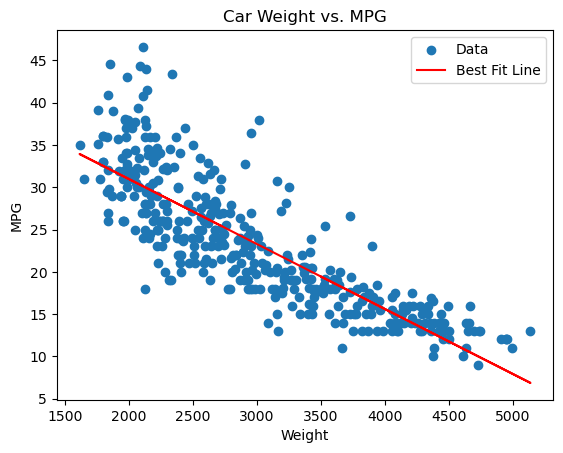

In [11]:
b = coeffs["Intercept"]
a = coeffs["weight"]

x_data = df_cars["weight"]
y_data_scatter = df_cars["mpg"]
y_data_plot = b + a*df_cars["weight"]

plt.scatter(x_data, y_data_scatter)
plt.plot(x_data, y_data_plot, color="red")
plt.legend(["Data", "Best Fit Line"])
plt.xlabel("Weight")
plt.ylabel("MPG")
plt.title("Car Weight vs. MPG")
plt.show()